In [59]:
from Bio.Blast import NCBIWWW
from Bio.Blast import NCBIXML
import requests
import numpy as np
import time
import os
import pandas as pd
import time
from requests import get
root = '/Users/k23030440/S.-Pombe-MLPs - most recent/'


def get_amino_acid_sequence(uniprot_id):
    base_url = "https://www.uniprot.org/uniprot/"
    response_format = ".fasta"

    # Combine the URL to get the FASTA format data for the given UniProt ID
    url = f"{base_url}{uniprot_id}{response_format}"

    try:
        response = requests.get(url)
        response.raise_for_status()  # Raise an exception for bad status codes (e.g., 404, 500)

        # Parse the response to extract the amino acid sequence
        lines = response.text.strip().split("\n")
        sequence = "".join(lines[1:])  # Skipping the first line (header)

        return sequence
    except requests.exceptions.RequestException as e:
        print(f"Error occurred while fetching the data: {e}")
        return None
    


In [24]:


def get_top_e_val(uniprot_id, max_retries=10):
    """
    Performs a BLAST search against the NCBI nr database for the given UniProt ID.
    Returns the top hit's e-value and score.

    :param uniprot_id: The UniProt ID to search for.
    :param max_retries: The maximum number of times to retry the BLAST search if it fails.
    """



    query_sequence = get_amino_acid_sequence(uniprot_id)
    hits = []

    #values to return
    cerevisiae_e_val = np.nan
    cerevisiae_score = np.nan
    cerevisiae_symbol = "N/A"
    albicans_e_val = np.nan
    albicans_score = np.nan
    albicans_symbol = "N/A"

    for retry in range(max_retries + 1):
        try:
            # Perform the BLAST search
            print("BLAST starts")



            result_handle = NCBIWWW.qblast("blastp", "nr", query_sequence, expect=1000, entrez_query="txid237561[ORGN] OR txid5476[ORGN] OR txid559292[ORGN] OR txid4932[ORGN]",hitlist_size=1000)

            blast_records = NCBIXML.parse(result_handle)

            hits = []
            for blast_record in blast_records:
                for alignment in blast_record.alignments:
                    for hsp in alignment.hsps:
                        hit_info = {
                                        "accession": alignment.accession,
                                        "description": alignment.title,
                                        "evalue": hsp.expect,
                                        "score": hsp.score
                                    }
                        hits.append(hit_info)
            #in hits find entries, where description contains the string "Saccharomyces cerevisiae"
            cerevisiae_entries = [hit for hit in hits if "Saccharomyces cerevisiae" in hit["description"]]
            albicans_entries = [hit for hit in hits if "Candida albicans" in hit["description"]]
            #order these by hgihest score first lowest score last
            cerevisiae_entries = sorted(cerevisiae_entries, key=lambda x: x["score"], reverse=True)
            albicans_entries = sorted(albicans_entries, key=lambda x: x["score"], reverse=True)

            if len(cerevisiae_entries) > 0:
                cerevisiae_e_val = cerevisiae_entries[0]["evalue"]
                cerevisiae_score = cerevisiae_entries[0]["score"]
                cerevisiae_symbol = cerevisiae_entries[0]["accession"]
            
            
            if len(albicans_entries) > 0:
                albicans_e_val = albicans_entries[0]["evalue"]
                albicans_score = albicans_entries[0]["score"]
                albicans_symbol = albicans_entries[0]["accession"]

            return cerevisiae_e_val, cerevisiae_score, cerevisiae_symbol, albicans_e_val, albicans_score, albicans_symbol

        except Exception as e:
            print(f"Error during attempt {retry + 1}: {e}")
            if retry < max_retries:
                print("Retrying...")
                time.sleep(60)  # Add a delay before retrying
            else:
                print(f"Max retries reached, returning default values.")
                return cerevisiae_e_val, cerevisiae_score, cerevisiae_symbol, albicans_e_val, albicans_score, albicans_symbol


In [25]:
#import pombase gene products file
import pandas as pd
import numpy as np
root = "/Users/bencekover/Library/CloudStorage/OneDrive-Personal/MSci Bahler lab/S.-Pombe-MLPs - Github/"
gene_info = pd.read_csv(root + "external data/Pombase files/gene_IDs_names_products.tsv", sep='\t', header=0)
gene_info = gene_info[["SPAC1002.01", "Q9US57", "mrx11"]]
gene_info = gene_info.rename(columns={"SPAC1002.01": "ID", "Q9US57": "uniprot", "mrx11":"gene_name"})

orthology_db = pd.read_csv(root + "Bence folder/Orthologs/final_orthology_database.csv")
#fetch the list of pombe_gene_IDs with orthopattern 7 and 1 into lists called conserved, unique
unique_genes= orthology_db[orthology_db['orthopattern'] == 1]["pombe_name(s)"].values
unique_genes = np.array([element[2:-2] for element in unique_genes])
unique_genes_uniprot = np.array([])
to_be_deleted = np.array([],dtype=int)
for i in range(len(unique_genes)):
    #find in gene_info the uniprot ID of the gene
    try:
        unique_genes_uniprot = np.append(unique_genes_uniprot, gene_info[gene_info["ID"] == unique_genes[i]]["uniprot"].values[0])
    except:
        unique_genes_uniprot = unique_genes_uniprot
        #remove that entry from unique_genes
        to_be_deleted = np.append(to_be_deleted, i)
unique_genes = np.delete(unique_genes, to_be_deleted)



conserved_genes= orthology_db[orthology_db['orthopattern'] == 7]["pombe_name(s)"].values
conserved_genes = np.array([element[2:-2] for element in conserved_genes])
#take uniprot IDs but in the same order!
conserved_genes_uniprot = np.array([])
to_be_deleted = np.array([],dtype=int)
for i in range(len(conserved_genes)):
    try:
        conserved_genes_uniprot = np.append(conserved_genes_uniprot, gene_info[gene_info["ID"] == conserved_genes[i]]["uniprot"].values[0])
    except:
        conserved_genes_uniprot = conserved_genes_uniprot
        to_be_deleted = np.append(to_be_deleted, i)
conserved_genes = np.delete(conserved_genes, to_be_deleted)



In [26]:
conserved_e_vals_cerevisiae = np.full(50, np.nan)
conserved_scores_cerevisiae = np.full(50, np.nan)
conserved_e_vals_albicans = np.full(50, np.nan)
conserved_scores_albicans = np.full(50, np.nan)
conserved_symbols_cerevisiae = np.full(50, "N/A")
conserved_symbols_albicans = np.full(50, "N/A")

In [27]:

try:
    conserved_e_vals_cerevisiae = np.loadtxt('conserved_e_vals_cerevisiae_final.txt')
    #drop all values after the last non nan value
    n_entries = np.where(~np.isnan(conserved_e_vals_cerevisiae))[0][-1]
    
    conserved_e_vals_cerevisiae = conserved_e_vals_cerevisiae[:n_entries]
    #fill the rest with nan
    conserved_e_vals_cerevisiae = np.append(conserved_e_vals_cerevisiae, np.full(50-n_entries, np.nan))
    print("file loaded, entries:", n_entries)

except:
    conserved_e_vals_cerevisiae = np.full(50, np.nan)

try:
    conserved_scores_cerevisiae = np.loadtxt('conserved_scores_cerevisiae_final.txt')
    conserved_scores_cerevisiae = conserved_scores_cerevisiae[:n_entries]
    conserved_scores_cerevisiae = np.append(conserved_scores_cerevisiae, np.full(50-n_entries, np.nan))
    print("file loaded, entries:",n_entries)
except:
    conserved_scores_cerevisiae = np.full(50, np.nan)

try:
    conserved_e_vals_albicans = np.loadtxt('conserved_e_vals_albicans_final.txt')
    conserved_e_vals_albicans = conserved_e_vals_albicans[:n_entries]
    conserved_e_vals_albicans = np.append(conserved_e_vals_albicans, np.full(50-n_entries, np.nan))
    print("file loaded, entries:", n_entries)
except:
    conserved_e_vals_albicans = np.full(50, np.nan)

try:
    conserved_scores_albicans = np.loadtxt('conserved_scores_albicans_final.txt')
    conserved_scores_albicans = conserved_scores_albicans[:n_entries]
    conserved_scores_albicans = np.append(conserved_scores_albicans, np.full(50-n_entries, np.nan))
    print("file loaded, entries:", n_entries)

except:
    conserved_scores_albicans = np.full(50, np.nan)

try:
    conserved_symbols_cerevisiae = np.loadtxt('conserved_symbols_cerevisiae_final.txt', dtype=str)
    conserved_symbols_cerevisiae = conserved_symbols_cerevisiae[:n_entries]
    conserved_symbols_cerevisiae = np.append(conserved_symbols_cerevisiae, np.full(50-n_entries, "N/A"))
    print("file loaded, entries:", len(n_entries))

except:
    conserved_symbols_cerevisiae = np.full(50, "N/A")

try:
    conserved_symbols_albicans = np.loadtxt('conserved_symbols_albicans_final.txt', dtype=str)
    conserved_symbols_albicans = conserved_symbols_albicans[:n_entries]
    conserved_symbols_albicans = np.append(conserved_symbols_albicans, np.full(50-n_entries, "N/A"))
    print("file loaded, entries:", len(n_entries))

except:
    conserved_symbols_albicans = np.full(50, "N/A")



for i in range(n_entries,50):

    cerevisiae_e_val, cerevisiae_score, cerevisiae_symbol, albicans_e_val, albicans_score, albicans_symbol = get_top_e_val(conserved_genes_uniprot[i]) 
    print(cerevisiae_e_val, cerevisiae_score, cerevisiae_symbol, albicans_e_val, albicans_score, albicans_symbol,conserved_genes[i],conserved_genes_uniprot[i])
    print("currently at entry", i, "of", len(conserved_genes_uniprot))
    conserved_e_vals_cerevisiae[i] = cerevisiae_e_val
    conserved_scores_cerevisiae[i] = cerevisiae_score
    conserved_symbols_cerevisiae[i] = cerevisiae_symbol
    conserved_e_vals_albicans[i] = albicans_e_val
    conserved_scores_albicans[i] = albicans_score
    conserved_symbols_albicans[i] = albicans_symbol




file loaded, entries: 49
file loaded, entries: 49
file loaded, entries: 49
file loaded, entries: 49
BLAST starts
2.49563e-69 600.0 CAI5238588 4.4486e-63 551.0 KGU29933 SPAC22H10.07 P40996
currently at entry 49 of 1070


In [209]:

np.savetxt('conserved_e_vals_cerevisiae_final.txt', conserved_e_vals_cerevisiae)
np.savetxt('conserved_e_vals_albicans_final.txt', conserved_e_vals_albicans)
np.savetxt('conserved_symbols_cerevisiae_final.txt', conserved_symbols_cerevisiae, fmt="%s")
np.savetxt('conserved_scores_cerevisiae_final.txt', conserved_scores_cerevisiae)
np.savetxt('conserved_scores_albicans_final.txt', conserved_scores_albicans)
np.savetxt('conserved_symbols_albicans_final.txt', conserved_symbols_albicans, fmt="%s")


In [213]:
np.savetxt('unique_e_vals_cerevisiae_final.txt', unique_e_vals_cerevisiae)
np.savetxt('unique_e_vals_albicans_final.txt', unique_e_vals_albicans)
np.savetxt('unique_scores_cerevisiae_final.txt', unique_scores_cerevisiae)
np.savetxt('unique_scores_albicans_final.txt', unique_scores_albicans)
np.savetxt('unique_symbols_cerevisiae_final.txt', unique_symbols_cerevisiae, fmt="%s")
np.savetxt('unique_symbols_albicans_final.txt', unique_symbols_albicans, fmt="%s")

In [28]:

try:
    unique_e_vals_cerevisiae = np.loadtxt('unique_e_vals_cerevisiae_final.txt')
    #drop all values after the last non nan value
    n_entries = np.where(~np.isnan(unique_e_vals_cerevisiae))[0][-1]
    
    unique_e_vals_cerevisiae = unique_e_vals_cerevisiae[:n_entries]
    #fill up with nans
    unique_e_vals_cerevisiae = np.append(unique_e_vals_cerevisiae, np.full(len(unique_genes_uniprot)-n_entries, np.nan))
    print("file loaded, entries:", n_entries)

except:
    unique_e_vals_cerevisiae = np.array([])

try:
    unique_scores_cerevisiae = np.loadtxt('unique_scores_cerevisiae_final.txt')
    unique_scores_cerevisiae = unique_scores_cerevisiae[:n_entries]
    unique_scores_cerevisiae = np.append(unique_scores_cerevisiae, np.full(len(unique_genes_uniprot)-n_entries, np.nan))
    print("file loaded, entries:", n_entries)
except:
    unique_scores_cerevisiae = np.array([])

try:
    unique_e_vals_albicans = np.loadtxt('unique_e_vals_albicans_final.txt')
    unique_e_vals_albicans = unique_e_vals_albicans[:n_entries]
    unique_e_vals_albicans = np.append(unique_e_vals_albicans, np.full(len(unique_genes_uniprot)-n_entries, np.nan))
    print("file loaded, entries:", n_entries)
except:
    unique_e_vals_albicans = np.array([])

try:
    unique_scores_albicans = np.loadtxt('unique_scores_albicans_final.txt')
    unique_scores_albicans = unique_scores_albicans[:n_entries]
    unique_scores_albicans = np.append(unique_scores_albicans, np.full(len(unique_genes_uniprot)-n_entries, np.nan))
    print("file loaded, entries:", n_entries)
except:
    unique_scores_albicans = np.array([])



try:
    unique_symbols_cerevisiae = np.loadtxt('unique_symbols_cerevisiae_final.txt', dtype=str)
    unique_symbols_cerevisiae = unique_symbols_cerevisiae[:n_entries]
    unique_symbols_cerevisiae = np.append(unique_symbols_cerevisiae, np.full(len(unique_genes_uniprot)-n_entries, "N/A"))
    print("file loaded, entries:", n_entries)

except:
    unique_symbols_cerevisiae = np.full(len(unique_genes_uniprot), "N/A")

try:
    unique_symbols_albicans = np.loadtxt('unique_symbols_albicans_final.txt', dtype=str)
    unique_symbols_albicans = unique_symbols_albicans[:n_entries]
    unique_symbols_albicans = np.append(unique_symbols_albicans, np.full(len(unique_genes_uniprot)-n_entries, "N/A"))
    print("file loaded, entries:", n_entries)

except:
    unique_symbols_albicans = np.full(len(unique_genes_uniprot), "N/A")




for i in range(n_entries,len(unique_genes_uniprot)):

    cerevisiae_e_val, cerevisiae_score, cerevisiae_symbol, albicans_e_val, albicans_score, albicans_symbol = get_top_e_val(unique_genes_uniprot[i]) 
    print(cerevisiae_e_val, cerevisiae_score, cerevisiae_symbol, albicans_e_val, albicans_score, albicans_symbol,unique_genes[i],unique_genes_uniprot[i])
    print("currently at entry", i, "of", len(unique_genes_uniprot))
    unique_e_vals_cerevisiae[i] = cerevisiae_e_val
    unique_scores_cerevisiae[i] = cerevisiae_score
    unique_symbols_cerevisiae[i] = cerevisiae_symbol
    unique_e_vals_albicans[i] = albicans_e_val
    unique_scores_albicans[i] = albicans_score
    unique_symbols_albicans[i] = albicans_symbol


#np.savetxt('unique_e_vals_cerevisiae_final.txt', unique_e_vals_cerevisiae)
#np.savetxt('unique_e_vals_albicans_final.txt', unique_e_vals_albicans)
#np.savetxt('unique_scores_cerevisiae_final.txt', unique_scores_cerevisiae)
#np.savetxt('unique_scores_albicans_final.txt', unique_scores_albicans)
    


file loaded, entries: 24
file loaded, entries: 24
file loaded, entries: 24
file loaded, entries: 24
file loaded, entries: 24
file loaded, entries: 24
BLAST starts
7.41212e-30 336.0 CAI7443233 3.17771e-33 364.0 KGT71740 SPCC895.05 O94532
currently at entry 24 of 25


In [29]:
unique_e_vals_cerevisiae

array([        nan, 2.33312e+02,         nan, 1.77122e+01, 4.86412e+02,
               nan, 1.31248e-03, 1.56635e+02, 5.32609e-10, 2.50458e+02,
       2.86622e-23, 4.86412e+02, 7.38255e-08, 4.78427e+02,         nan,
       8.83257e-14, 7.45392e+00,         nan,         nan, 9.86924e-03,
               nan, 2.44881e-04,         nan, 1.15489e+02, 7.41212e-30])

In [ ]:
np.savetxt('unique_e_vals_cerevisiae_final.txt', unique_e_vals_cerevisiae)
np.savetxt('unique_e_vals_albicans_final.txt', unique_e_vals_albicans)
np.savetxt('unique_scores_cerevisiae_final.txt', unique_scores_cerevisiae)
np.savetxt('unique_scores_albicans_final.txt', unique_scores_albicans)

In [30]:
import os

def download_pdb_alphafold(uniprot_id, database_version='v2'):
    """
    Downloads the AlphaFold protein structure and predicted error file for a given uniprot id
    
    Parameters
    ----------
    uniprot_id : str
        Uniprot id of the protein of interest
    database_version : str, optional
        Version of the AlphaFold database to use (default is 'v2')
    """
    
    alphafold_id = f'AF-{uniprot_id}-F1'
    model_url = f'https://alphafold.ebi.ac.uk/files/{alphafold_id}-model_{database_version}.pdb'
    error_url = f'https://alphafold.ebi.ac.uk/files/{alphafold_id}-predicted_aligned_error_{database_version}.json'

    os.system(f'curl {model_url} -o {alphafold_id}.pdb')
    os.system(f'curl {error_url} -o {alphafold_id}.json')

In [31]:
import time
import subprocess
#import get
from requests import get

def scores_evals_from_uniprot(uniprot_id):
    """
    Returns the e-value and score of the best hit in S. cerevisiae and C. albicans for a given uniprot id
    
    Parameters
    ----------
    uniprot_id : str
        Uniprot id of the protein of interest
    """


    download_pdb_alphafold(uniprot_id)
    file = f'/Users/bencekover/Library/CloudStorage/OneDrive-Personal/MSci\ Bahler\ lab/S.-Pombe-MLPs\ -\ Github/Bence\ folder/Structure_and_Sequence_comparisons/{uniprot_id}.pdb'
    
    x=0
    
    while x < 5:
        try:
            job = !curl -X POST -F q=@{file} -F 'mode=3diaa' -F 'database[]=afdb-swissprot' https://search.foldseek.com/api/ticket
            job = job[-1].split('"')[3]
            result = get('https://search.foldseek.com/api/result/' + job + '/0').json()
            x = 5
        except:
            time.sleep(60)
            x += 1
            print("waiting")
           
    try:
        taxids = [result["results"][0]["alignments"][i]["taxId"] for i in range(len(result["results"][0]["alignments"]))]
        scores = [result["results"][0]["alignments"][i]["score"] for i in range(len(result["results"][0]["alignments"]))]
        evals = [result["results"][0]["alignments"][i]["eval"] for i in range(len(result["results"][0]["alignments"]))]

        #for top_score_cerevisiae find in taxids the entry which equals 4932 or 559292 and get the highest score and evalue from those
        cerevisiae_index = [i for i, x in enumerate(taxids) if x == 4932 or x == 559292]
        albicans_index = [i for i, x in enumerate(taxids) if x == 5476 or x== 237561]
    except:
        return 0,100,0,100
    try:
        top_cerevisiae_score = max([scores[i] for i in cerevisiae_index])
        top_cerevisiae_eval = min([evals[i] for i in cerevisiae_index])
    except:
        print("no cerevisiae")
        top_cerevisiae_score = 0
        top_cerevisiae_eval = 100
        

        #do the same for albicans
        
    try:
        top_albicans_score = max([scores[i] for i in albicans_index])
        top_albicans_eval = min([evals[i] for i in albicans_index])
    except:
        print("no albicans")
        top_albicans_score = 0
        top_albicans_eval = 100
        
    #remove .pdb file
    os.remove(f'/Users/bencekover/Library/CloudStorage/OneDrive-Personal/MSci\ Bahler\ lab/S.-Pombe-MLPs\ -\ Github/Bence\ folder/Structure_and_Sequence_comparisons/{uniprot_id}.pdb')

    return top_cerevisiae_score, top_cerevisiae_eval, top_albicans_score, top_albicans_eval




In [103]:
np.savetxt('unique_e_vals_cerevisiae_foldseek.txt', unique_e_vals_cerevisiae_foldseek)
np.savetxt('unique_scores_cerevisiae_foldseek.txt', unique_scores_cerevisiae_foldseek)
np.savetxt('unique_e_vals_albicans_foldseek.txt', unique_e_vals_albicans_foldseek)
np.savetxt('unique_scores_albicans_foldseek.txt', unique_scores_albicans_foldseek)

In [36]:
np.loadtxt('unique_e_vals_cerevisiae_foldseek.txt')

array([nan, nan, nan, nan, nan, nan, nan])

In [37]:

try:
    unique_e_vals_cerevisiae_foldseek = np.loadtxt('unique_e_vals_cerevisiae_foldseek_final.txt')
    #drop all values after the last non nan value
    n_entries = np.where(~np.isnan(unique_e_vals_cerevisiae_foldseek))[0][-1]
    unique_e_vals_cerevisiae_foldseek = unique_e_vals_cerevisiae_foldseek[:n_entries]
    #fill up the rest until len(unique_genes_uniprot) with nan
    unique_e_vals_cerevisiae_foldseek = np.append(unique_e_vals_cerevisiae_foldseek, np.full(len(unique_genes_uniprot)-n_entries, np.nan))
    print("file loaded, entries:", n_entries)

except:
    unique_e_vals_cerevisiae_foldseek = np.full(len(unique_genes_uniprot), np.nan)

try:
    unique_scores_cerevisiae_foldseek = np.loadtxt('unique_scores_cerevisiae_foldseek_final.txt')
    unique_scores_cerevisiae_foldseek = unique_scores_cerevisiae_foldseek[:n_entries]
    unique_scores_cerevisiae_foldseek = np.append(unique_scores_cerevisiae_foldseek, np.full(len(unique_genes_uniprot)-n_entries, np.nan))

    print("file loaded, entries:", n_entries)
except:
    unique_scores_cerevisiae_foldseek = np.full(len(unique_genes_uniprot), np.nan)

try:
    unique_e_vals_albicans_foldseek = np.loadtxt('unique_e_vals_albicans_foldseek_final.txt')
    unique_e_vals_albicans_foldseek = unique_e_vals_albicans_foldseek[:n_entries]
    unique_e_vals_albicans_foldseek = np.append(unique_e_vals_albicans_foldseek, np.full(len(unique_genes_uniprot)-n_entries, np.nan))
    print("file loaded, entries:", n_entries)
except:
    unique_e_vals_albicans_foldseek = np.full(len(unique_genes_uniprot), np.nan)

try:
    unique_scores_albicans_foldseek  = np.loadtxt('unique_scores_albicans_foldseek_final.txt')
    unique_scores_albicans_foldseek  = unique_scores_albicans_foldseek [:n_entries]
    unique_scores_albicans_foldseek  = np.append(unique_scores_albicans_foldseek , np.full(len(unique_genes_uniprot)-n_entries, np.nan))
    print("file loaded, entries:", n_entries)

except:
    unique_scores_albicans_foldseek = np.full(len(unique_genes_uniprot), np.nan)

try:
    for i in range(n_entries,len(unique_genes_uniprot)):
        score_cerevisiae, eval_cerevisiae, score_albicans, eval_albicans = scores_evals_from_uniprot(unique_genes_uniprot[i])
        print(score_cerevisiae, eval_cerevisiae, score_albicans, eval_albicans, unique_genes[i], unique_genes_uniprot[i])
        print("currently at entry", i, "of", len(unique_genes_uniprot), "entries top")
        unique_e_vals_cerevisiae_foldseek[i] = eval_cerevisiae
        unique_scores_cerevisiae_foldseek[i] = score_cerevisiae
        unique_e_vals_albicans_foldseek[i] = eval_albicans
        unique_scores_albicans_foldseek[i] = score_albicans

except:
    for i in range(len(unique_genes_uniprot)):
        score_cerevisiae, eval_cerevisiae, score_albicans, eval_albicans = scores_evals_from_uniprot(unique_genes_uniprot[i])
        print(score_cerevisiae, eval_cerevisiae, score_albicans, eval_albicans, unique_genes[i], unique_genes_uniprot[i])
        print("currently at entry", i, "of", len(unique_genes_uniprot), "entries bot")
        unique_e_vals_cerevisiae_foldseek[i] = eval_cerevisiae
        unique_scores_cerevisiae_foldseek[i] = score_cerevisiae
        unique_e_vals_albicans_foldseek[i] = eval_albicans
        unique_scores_albicans_foldseek[i] = score_albicans

np.savetxt('unique_e_vals_cerevisiae_foldseek.txt', unique_e_vals_cerevisiae_foldseek)
np.savetxt('unique_scores_cerevisiae_foldseek.txt', unique_scores_cerevisiae_foldseek)
np.savetxt('unique_scores_albicans_foldseek.txt', unique_scores_albicans_foldseek)
np.savetxt('unique_e_vals_albicans_foldseek.txt', unique_e_vals_albicans_foldseek)



  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  937k    0  937k    0     0   397k      0 --:--:--  0:00:02 --:--:--  397k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 27.2M    0 27.2M    0     0  3784k      0 --:--:--  0:00:07 --:--:-- 3784k


waiting
waiting
waiting
waiting
waiting
0 100 0 100 SPCC895.05 O94532
currently at entry 24 of 25 entries top


In [40]:

try:
    conserved_e_vals_cerevisiae_foldseek = np.loadtxt('conserved_e_vals_cerevisiae_final.txt')
    #drop all values after the last non nan value
    n_entries = np.where(~np.isnan(conserved_e_vals_cerevisiae_foldseek))[0][-1]
    
    conserved_e_vals_cerevisiae_foldseek = conserved_e_vals_cerevisiae_foldseek[:n_entries]
    print("file loaded, entries:", len(n_entries))

except:
    conserved_e_vals_cerevisiae_foldseek = np.full(50, np.nan)

try:
    conserved_scores_cerevisiae_foldseek = np.loadtxt('conserved_scores_cerevisiae_final.txt')
    conserved_scores_cerevisiae_foldseek = conserved_scores_cerevisiae_foldseek[:n_entries]
    print("file loaded, entries:", len(n_entries))
except:
    conserved_scores_cerevisiae_foldseek = np.full(50, np.nan)

try:
    conserved_e_vals_albicans_foldseek = np.loadtxt('conserved_e_vals_albicans_final.txt')
    conserved_e_vals_albicans_foldseek = conserved_e_vals_albicans_foldseek[:n_entries]
    print("file loaded, entries:", len(n_entries))
except:
    conserved_e_vals_albicans_foldseek = np.full(50, np.nan)

try:
    conserved_scores_albicans_foldseek  = np.loadtxt('conserved_scores_albicans_final.txt')
    conserved_scores_albicans_foldseek  = conserved_scores_albicans_foldseek [:n_entries]
    print("file loaded, entries:", len(n_entries))

except:
    conserved_scores_albicans_foldseek = np.full(50, np.nan)

try:
    for i in range(n_entries,50):
        score_cerevisiae, eval_cerevisiae, score_albicans, eval_albicans = scores_evals_from_uniprot(conserved_genes_uniprot[i])
        print(score_cerevisiae, eval_cerevisiae, score_albicans, eval_albicans, conserved_genes[i], conserved_genes_uniprot[i])

        conserved_e_vals_cerevisiae_foldseek[i] = eval_cerevisiae
        conserved_scores_cerevisiae_foldseek[i] = score_cerevisiae
        conserved_e_vals_albicans_foldseek[i] = eval_albicans
        conserved_scores_albicans_foldseek[i] = score_albicans

except:
    for i in range(50):
        score_cerevisiae, eval_cerevisiae, score_albicans, eval_albicans = scores_evals_from_uniprot(conserved_genes_uniprot[i])
        print(score_cerevisiae, eval_cerevisiae, score_albicans, eval_albicans, conserved_genes[i], conserved_genes_uniprot[i])

        conserved_e_vals_cerevisiae_foldseek[i] = eval_cerevisiae
        conserved_scores_cerevisiae_foldseek[i] = score_cerevisiae
        conserved_e_vals_albicans_foldseek[i] = eval_albicans
        conserved_scores_albicans_foldseek[i] = score_albicans

#np.savetxt('conserved_e_vals_cerevisiae_foldseek.txt', conserved_e_vals_cerevisiae_foldseek)
#np.savetxt('conserved_scores_cerevisiae_foldseek.txt', conserved_scores_cerevisiae_foldseek)
#np.savetxt('conserved_e_vals_albicans_foldseek.txt', conserved_e_vals_albicans_foldseek)
#np.savetxt('conserved_scores_albicans_foldseek.txt', conserved_scores_albicans_foldseek)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  341k    0  341k    0     0  1231k      0 --:--:-- --:--:-- --:--:-- 1236k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3494k    0 3494k    0     0  3873k      0 --:--:-- --:--:-- --:--:-- 3870k


waiting
waiting
waiting
waiting
waiting
0 100 0 100 SPAC22H10.07 P40996


In [104]:
np.savetxt('conserved_e_vals_cerevisiae_foldseek.txt', conserved_e_vals_cerevisiae_foldseek)
np.savetxt('conserved_scores_cerevisiae_foldseek.txt', conserved_scores_cerevisiae_foldseek)
np.savetxt('conserved_e_vals_albicans_foldseek.txt', conserved_e_vals_albicans_foldseek)
np.savetxt('conserved_scores_albicans_foldseek.txt', conserved_scores_albicans_foldseek)

# Plotting the results



In [41]:
all_uniprot_ids = np.concatenate((unique_genes_uniprot, conserved_genes_uniprot[:50], unique_genes_uniprot, conserved_genes_uniprot[:50], unique_genes_uniprot, conserved_genes_uniprot[:50], unique_genes_uniprot, conserved_genes_uniprot[:50]))
all_gene_names = np.concatenate((unique_genes, conserved_genes[:50], unique_genes, conserved_genes[:50], unique_genes, conserved_genes[:50], unique_genes, conserved_genes[:50]))
all_scores = np.concatenate((unique_scores_cerevisiae, conserved_scores_cerevisiae[:50], unique_scores_cerevisiae_foldseek, conserved_scores_cerevisiae_foldseek[:50], unique_scores_albicans, conserved_scores_albicans[:50], unique_scores_albicans_foldseek, conserved_scores_albicans_foldseek[:50]))
all_e_vals = np.concatenate((unique_e_vals_cerevisiae, conserved_e_vals_cerevisiae[:50], unique_e_vals_cerevisiae_foldseek, conserved_e_vals_cerevisiae_foldseek[:50], unique_e_vals_albicans, conserved_e_vals_albicans[:50], unique_e_vals_albicans_foldseek, conserved_e_vals_albicans_foldseek[:50]))
unique_conserved = np.concatenate((np.full(len(unique_genes), 'unique'), np.full(50, 'conserved'), np.full(len(unique_genes), 'unique'), np.full(50, 'conserved'), np.full(len(unique_genes), 'unique'), np.full(50, 'conserved'), np.full(len(unique_genes), 'unique'), np.full(50, 'conserved')))
data_sources = np.concatenate((np.full(len(unique_genes), 'BlastP'), np.full(50, 'BlastP'), np.full(len(unique_genes), 'Foldseek'), np.full(50, 'Foldseek'), np.full(len(unique_genes), 'BlastP'), np.full(50, 'BlastP'), np.full(len(unique_genes), 'Foldseek'), np.full(50, 'Foldseek')))
#species S. cerevisiae or C. albicans
species = np.concatenate((np.full(len(unique_genes), 'S. cerevisiae'), np.full(50, 'S. cerevisiae'), np.full(len(unique_genes), 'S. cerevisiae'), np.full(50, 'S. cerevisiae'), np.full(len(unique_genes), 'C. albicans'), np.full(50, 'C. albicans'), np.full(len(unique_genes), 'C. albicans'), np.full(50, 'C. albicans')))
#create a df with uniprot IDs, gene names, scores and e-values, data_source, unique/conserved, species
df = pd.DataFrame({'uniprot_id': all_uniprot_ids, 'gene_name': all_gene_names, 'score': all_scores, 'e_value': all_e_vals, 'unique_conserved': unique_conserved, 'data_source': data_sources, 'species': species})


In [42]:
pombe_floc_dict = {"SPAC186.01":"pfl9",
                   "SPAC1F8.06":"pfl8",
                   "SPBC359.04c":"pfl7",
                   "SPAC977.07c":"pfl6",
                   "SPBC1289.15":"pfl5",
                   "SPCC188.09c":"pfl4",
                   "SPBC947.04":"pfl3",
                   "SPAP11E10.02c":"mam3",
                   "SPAPB15E9.01c":"pfl2",
                   "SPAPB2C8.01":"SPAPB2C8.01",
                   "SPBC1348.08c":"SPBC1348.08c",
                   "SPBC21D10.06c":"map4",
                   "SPBPJ4664.02":"SPBPJ4664.02",
                   "SPCC1742.01":"gsf2"}

df["color"] = ["True (n=14)" if x in pombe_floc_dict.keys() else "False" for x in df["gene_name"]]



In [43]:
#in df, for e_value turn Na into 100
df['e_value'] = df['e_value'].fillna(100)
#for score fill with 0
df['score'] = df['score'].fillna(0)
#any e_value higher than 100, turn into 100
df['e_value'] = df['e_value'].apply(lambda x: 100 if x > 100 else x)
#if lower than 10e-50, turn into 10e-50
df['e_value'] = df['e_value'].apply(lambda x: 10e-150 if x < 10e-150 else x)
#save df
#df.to_csv("analysis.csv", index=False)

In [3]:
#load df
df = pd.read_csv("final_analysis.csv")

In [36]:
tab10

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

/var/folders/g6/4flmdffs7l35hmmt1wkgrfcm0000gr/T/ipykernel_80458/2661936576.py:18: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.stripplot(x="species", y="score", hue="unique_conserved", data=sub_df2, palette=palette, ax=(ax1, ax2)[i], dodge=True, alpha=0.4, size=8)
/var/folders/g6/4flmdffs7l35hmmt1wkgrfcm0000gr/T/ipykernel_80458/2661936576.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  (ax1, ax2)[i].set_xticklabels(labels, fontdict={'fontsize': 15, 'fontstyle': 'italic'})
/var/folders/g6/4flmdffs7l35hmmt1wkgrfcm0000gr/T/ipykernel_80458/2661936576.py:18: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.stripplot(x="species", y="score", hue="unique_conserved", data=sub_df2, palette=palette, ax=(ax1, ax2)[i], dodge=True, alpha=0.4, size=8)
/var/folders/g6/4flmdffs7l35hmmt1wkgrfcm0000gr/T/ipykerne

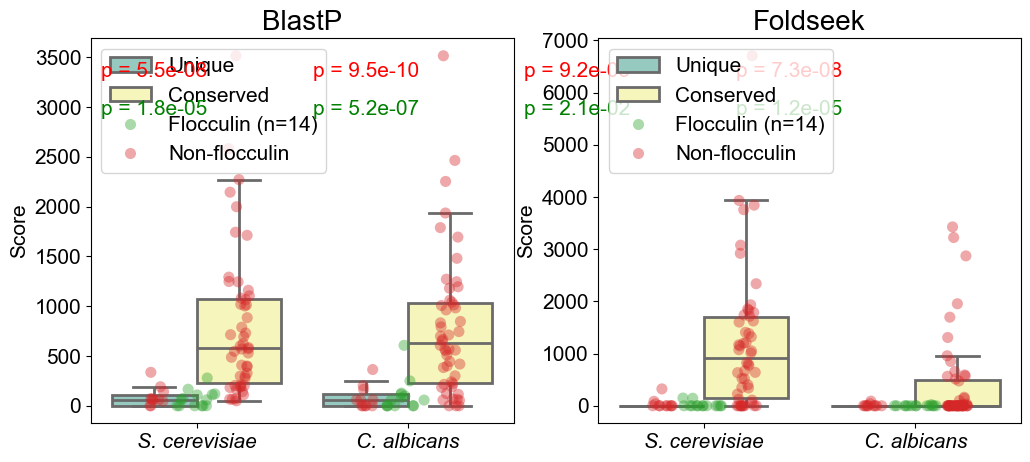

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt

#arial
plt.rcParams['font.family'] = 'Arial'
#create two plots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
for i in range(2):
# Create the boxplot
    sub_df = df[df["data_source"] == ["BlastP", "Foldseek"][i]]
    #thicker lines
    sns.boxplot(x="species", y="score", hue="unique_conserved", data=sub_df, palette="Set3", ax=(ax1, ax2)[i], showfliers=False, linewidth=2)
    sub_df2 = sub_df[sub_df["color"] == "True (n=14)"]
    #palette is tab10 9th col
    tab10= sns.color_palette("tab10", 10)
    palette=[tab10[2],tab10[2]]
    
    sns.stripplot(x="species", y="score", hue="unique_conserved", data=sub_df2, palette=palette, ax=(ax1, ax2)[i], dodge=True, alpha=0.4, size=8)
    sub_df3 = sub_df[sub_df["color"] == "False"]
    palette=[tab10[3],tab10[3]]
    
    sns.stripplot(x="species", y="score", hue="unique_conserved", data=sub_df3, palette=palette, ax=(ax1, ax2)[i], dodge=True, alpha=0.4, size=8)

    #larger ticks and labels
    (ax1, ax2)[i].tick_params(axis='y', which='major', labelsize=15)
    (ax1, ax2)[i].tick_params(axis='y', which='minor', labelsize=15)
    #x ticks large as well and italics
    labels = (ax1, ax2)[i].get_xticklabels()
    (ax1, ax2)[i].set_xticklabels(labels, fontdict={'fontsize': 15, 'fontstyle': 'italic'})
    
    #y label
    (ax1, ax2)[i].set_ylabel("Score", fontsize=15)
    #title
    (ax1, ax2)[i].set_title(["BlastP", "Foldseek"][i], fontsize=20)
    #no x label
    (ax1, ax2)[i].set_xlabel("")
    
    handles, labels = (ax1, ax2)[i].get_legend_handles_labels()
    handles = handles[:4]
    labels = labels[:4]
    labels[-1] = "Non-flocculin"
    labels[-2] = "Flocculin (n=14)"
    labels[-3] = "Conserved"
    labels[-4] = "Unique"

    (ax1, ax2)[i].legend(handles, labels, loc='upper left', fontsize=15)
    

# Calculate p-values
p_vals = []
p_vals_floc = []
species_data_sources = [
    ('C. albicans', 'BlastP'),
    ('S. cerevisiae', 'BlastP'),
    ('C. albicans', 'Foldseek'),
    ('S. cerevisiae', 'Foldseek')

]

for species, data_source in species_data_sources:
    unique_scores = df[(df['unique_conserved'] == 'unique') & (df['species'] == species) & (df['data_source'] == data_source)]['score']
    unique_floc_scores = df[(df['unique_conserved'] == 'unique') & (df['species'] == species) & (df['data_source'] == data_source) & (df['color'] == "True (n=14)")]['score']
    conserved_scores = df[(df['unique_conserved'] == 'conserved') & (df['species'] == species) & (df['data_source'] == data_source)]['score']
    p_val = stats.mannwhitneyu(unique_scores, conserved_scores, alternative='two-sided')[1]
    p_vals.append(p_val)
    p_val_floc = stats.mannwhitneyu(unique_floc_scores, conserved_scores, alternative='two-sided')[1]
    p_vals_floc.append(p_val_floc)

# Create the text labels
p_vals_labels = ["p = {:.1e}".format(p_val) for p_val in p_vals]
p_vals_labels_floc = ["p = {:.1e}".format(p_val_floc) for p_val_floc in p_vals_floc]


#first two p_vals_labels go for ax1, last two for ax2 with red color
#first two p_vals_labels_floc go for ax1, last two for ax2 with green color
for i in range(len(p_vals_labels_floc)):
    plt.text((i+0.05)*0.5, 0.9, p_vals_labels[i], transform=ax1.transAxes, fontsize=15, color="red")
    plt.text((i+0.05)*0.5, 0.8, p_vals_labels_floc[i], transform=ax1.transAxes, fontsize=15, color="green")


#save as svg and png
plt.savefig(root + "Figures/All figures/blastp_foldseek_scores.svg", bbox_inches='tight')
plt.savefig(root + "Figures/All figures/blastp_foldseek_scores.png", bbox_inches='tight')


In [52]:
p_vals_labels

['p = 5.477e-08', 'p = 9.466e-10', 'p = 9.172e-03', 'p = 7.274e-08']

In [16]:
import bokeh.io
from bokeh.plotting import figure, show
from bokeh.models import Text
from scipy import stats
import iqplot
import pandas as pd

# Your DataFrame (df) and other data

# Create the plot
p = iqplot.stripbox(df, q="score", cats=["data_source", "species", "unique_conserved"], color_column="color", q_axis="y", frame_width=350, frame_height=300, spread="jitter", jitter_kwargs={'width': 0.6},
                    marker_kwargs=dict(size=8, alpha=0.5), box_kwargs=dict(line_color="black", line_width=2), whisker_kwargs=dict(line_color="black", line_width=2), median_kwargs=dict(line_color="black", line_width=2), show_legend=True)

# Customizations
p.xaxis.major_label_orientation = 1.2
p.xaxis.axis_label_text_font_size = '12pt'
p.xaxis.major_label_text_font_size = '12pt'
p.yaxis.axis_label_text_font_size = '12pt'
p.xaxis.major_label_text_font_size = '12pt'
p.yaxis.major_label_text_font_size = '12pt'
p.xaxis.axis_label_text_font_style = 'normal'
p.yaxis.axis_label_text_font_style = 'normal'
p.yaxis.axis_label = 'Score'
p.legend.title = 'Flocculin genes'


# Adjust text label positions
x_positions = [1.3,4,7,9.7]  # Corresponding to the species and data_source combinations

y_positions = [4100,4300,4100,4300]


# Add text labels to the plot
for x, y, label in zip(x_positions, y_positions, p_vals_labels):
    text = Text(x=x, y=y+250, text=label, text_font_size='9.5pt', text_align='center', text_baseline='middle', text_color='black', text_alpha=1)
    #place it above all elements
    p.add_glyph(text, level='overlay')

for x, y, label in zip(x_positions, y_positions, p_vals_labels_floc):
    text = Text(x=x, y=y, text=label, text_font_size='9.5pt', text_align='center', text_baseline='middle', text_color='orange', text_alpha=1)
    p.add_glyph(text, level='overlay')

#ymax = 4800
p.y_range = bokeh.models.Range1d(0, 4800)
#make everything part of the same plot
p.output_backend = "svg"
p = bokeh.layouts.column(p)

bokeh.io.export_svg(p, filename=root + "Figures/All figures/blast_p_foldseek_results.svg")
bokeh.io.export_png(p, filename=root + "Figures/All figures/blast_p_foldseek_results.png")


ERROR:bokeh.core.validation.check:E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name. This could either be due to a misspelling or typo, or due to an expected column being missing. : text='p = 5.477e-08' [no close matches] {renderer: GlyphRenderer(id='p2065', ...)}
ERROR:bokeh.core.validation.check:E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name. This could either be due to a misspelling or typo, or due to an expected column being missing. : text='p = 9.172e-03' [no close matches] {renderer: GlyphRenderer(id='p2079', ...)}
ERROR:bokeh.core.validation.check:E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name. This could either be due to a misspelling or typo, or due to an expected column being missing. : text='p = 2.075e-02' [no close matches] {renderer: GlyphRenderer(id='p2107', ...)}
ERROR:bokeh.core.validation.check:E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name. This could either be due to a misspelling or typo, or du

RuntimeError: Neither firefox and geckodriver nor a variant of chromium browser and chromedriver are available on system PATH. You can install the former with 'conda install -c conda-forge firefox geckodriver'.

In [14]:
bokeh.io.show(p)

ERROR:bokeh.core.validation.check:E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name. This could either be due to a misspelling or typo, or due to an expected column being missing. : text='p = 1.250e-05' [no close matches] {renderer: GlyphRenderer(id='p1926', ...)}
ERROR:bokeh.core.validation.check:E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name. This could either be due to a misspelling or typo, or due to an expected column being missing. : text='p = 2.075e-02' [no close matches] {renderer: GlyphRenderer(id='p1919', ...)}
ERROR:bokeh.core.validation.check:E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name. This could either be due to a misspelling or typo, or due to an expected column being missing. : text='p = 5.158e-07' [no close matches] {renderer: GlyphRenderer(id='p1912', ...)}
ERROR:bokeh.core.validation.check:E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name. This could either be due to a misspelling or typo, or du

In [60]:
bokeh.io.show(p)


ERROR:bokeh.core.validation.check:E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name. This could either be due to a misspelling or typo, or due to an expected column being missing. : text='p = 5.158e-07' [no close matches] {renderer: GlyphRenderer(id='p1988', ...)}
ERROR:bokeh.core.validation.check:E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name. This could either be due to a misspelling or typo, or due to an expected column being missing. : text='p = 7.274e-08' [no close matches] {renderer: GlyphRenderer(id='p1974', ...)}
ERROR:bokeh.core.validation.check:E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name. This could either be due to a misspelling or typo, or due to an expected column being missing. : text='p = 2.075e-02' [no close matches] {renderer: GlyphRenderer(id='p1995', ...)}
ERROR:bokeh.core.validation.check:E-1001 (BAD_COLUMN_NAME): Glyph refers to nonexistent column name. This could either be due to a misspelling or typo, or du

In [ ]:
%load_ext watermark
%watermark


Last updated: 2023-11-04T15:29:09.583002+00:00

Python implementation: CPython
Python version       : 3.9.0
IPython version      : 7.31.1

Compiler    : Clang 11.0.0 
OS          : Darwin
Release     : 21.5.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit



In [ ]:
%watermark --iversions



numpy     : 1.23.4
pandas    : 1.4.4
matplotlib: 3.8.0

